In [1057]:
import warnings
warnings.filterwarnings('ignore')

In [158]:
import os
import copy

import pandas as pd
import numpy as np
import networkx as nx
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import pyvolve
import utils

## Comparisons of Models - WAG, LG, AB

In [2602]:
model_colors = mpl.cm.get_cmap('Accent').colors
property_colors = mpl.cm.get_cmap('tab10').colors

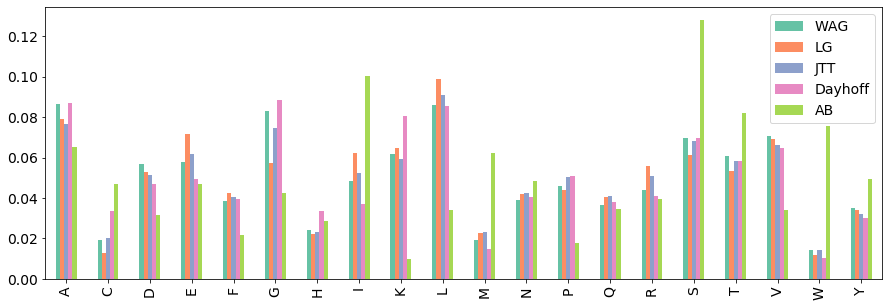

In [2588]:
freq_df = pd.DataFrame()
for modelname in ['WAG', 'LG', 'JTT', 'Dayhoff', 'AB']:
    model = pyvolve.Model(modelname)
    freq_df[modelname] = pd.Series(model.extract_state_freqs(), index = model.code)
freq_df.plot.bar(colors = model_colors, figsize = (15,5))

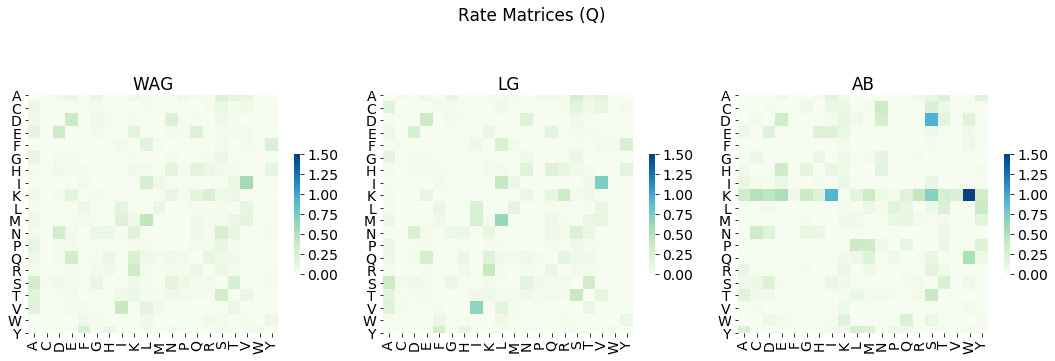

In [2600]:
fig, axs = plt.subplots(1, 3, figsize =(15,6))
fig.suptitle('Rate Matrices (Q)')
for i, modelname in enumerate(['WAG', 'LG', 'AB']):
    model = pyvolve.Model(modelname)
    rate_matrix = copy.deepcopy(model.matrix)
    np.fill_diagonal(rate_matrix, 0)
    sns.heatmap(rate_matrix,cmap = 'GnBu', ax = axs[i], label  = modelname,
                xticklabels=model.code,vmax = 1.5, square=True, cbar_kws={"shrink": .3} )
    axs[i].set_yticklabels(model.code, rotation = 'horizontal')
    axs[i].set_title(modelname)
plt.tight_layout()
#plt.savefig('/Poppy/vbhardwaj/shm_project/images/Q-matrices.png', dpi = 300)

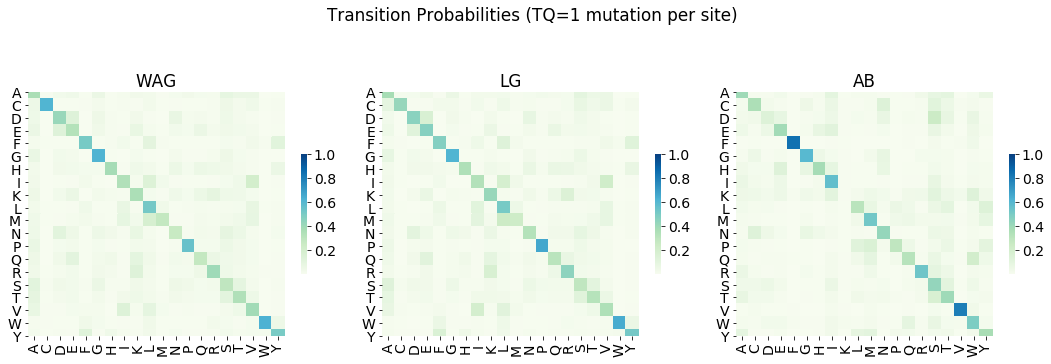

In [2599]:
fig, axs = plt.subplots(1, 3, figsize =(15,6))
fig.suptitle('Transition Probabilities (TQ=1 mutation per site)')
for i, modelname in enumerate(['WAG', 'LG', 'AB']):
    model = pyvolve.Model(modelname)
    rate_matrix = copy.deepcopy(model.matrix)
    sns.heatmap(scipy.linalg.expm(rate_matrix),cmap = 'GnBu', ax = axs[i], label  = modelname,
                xticklabels=model.code,vmax = 1., square=True, cbar_kws={"shrink": .3} )
    axs[i].set_yticklabels(model.code, rotation = 'horizontal')
    axs[i].set_title(modelname)
plt.tight_layout()
#plt.savefig('/Poppy/vbhardwaj/shm_project/images/P-matrices.png', dpi = 300)

## Delta Matrices for Amino acids

In [683]:
filename = '/Poppy/vbhardwaj/shm_project/aadelta_matrices.xlsx'

In [815]:
Delta = delta_matrices(volume = utils.get_delta_matrix(filename, 'volume'), 
                       polarity = utils.get_delta_matrix(filename, 'polarity'), 
                       aromaticity = utils.get_delta_matrix(filename, 'aromaticity'),
                       composition = utils.get_delta_matrix(filename, 'composition'))

In [816]:
Delta

Delta matrices of sizes  
Volume      - (20, 20)
Polarity    - (20, 20)
Aromaticity - (20, 20)
Composition - (20, 20)

Rows and columns for Volume
Rows    = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

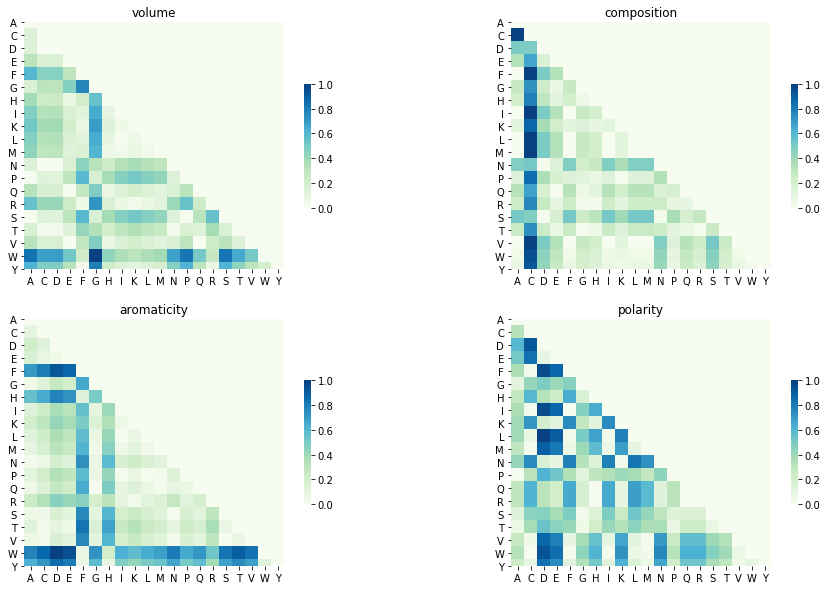

In [817]:
Delta.plot()

## For one clonal tree

In [2780]:
importlib.reload(utils)

<module 'utils' from '/Poppy/vbhardwaj/shm_project/utils.py'>

### Simulations

In [2781]:
CG_1615 = utils.clonal_graph(shm_file  = './Data/lineage1615_vertices30_shms.txt',
                             seqs_file = './Data/lineage1615_vertices30_seqs.txt')

In [2813]:
%%time
#null_dist = {}
num_cores = 50
n_sim = 100
for model in ['AB']:
    # Setup pyvolve model for simulations
    my_model = pyvolve.Model(model)
    my_partition = pyvolve.Partition(models = my_model, root_sequence = CG_1615.root_sequence)
    my_evolver = pyvolve.Evolver(partitions = my_partition, tree = CG_1615.pyvolve_phylogeny)
    
    # Clear the simulated data already present and do new simulations
    CG_1615.simulations = []
    for i in range(n_sim):
        my_evolver(write_anc = True,
                   ratefile = None,
                   infofile =  None,
                   seqfile =None )
        simulated_seqs = my_evolver.get_sequences(anc = True)
        CG_1615.simulations.append(simulated_seqs)
    
    # Get null distribution from simulated data
    null_dist[model] = CG_1615.sims_to_null_dists_parallel( Delta, cpus=num_cores) 
    

CPU times: user 30.8 s, sys: 58.6 s, total: 1min 29s
Wall time: 8.13 s


### Null distributions of different models

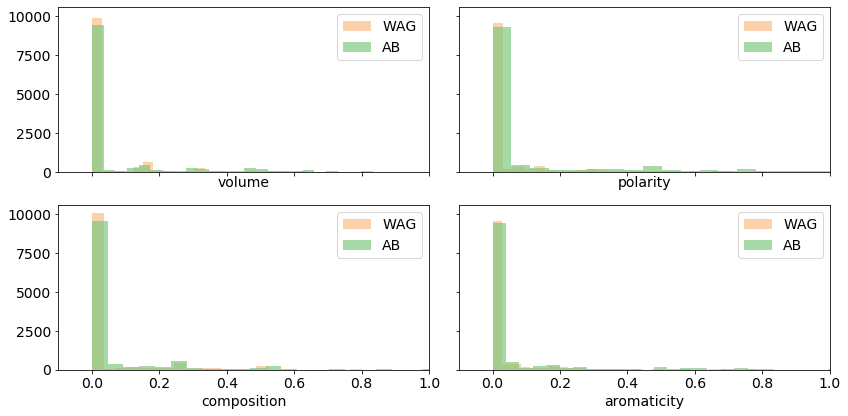

In [2784]:
fig, axs = plt.subplots(2, 2, figsize = (12,6), sharex=True, sharey=True)
axs = axs.ravel()
for i, a_property in enumerate(['volume', 'polarity', 'composition', 'aromaticity']):
    
    sns.distplot(null_dist['WAG'].loc[a_property], ax = axs[i],label = 'WAG', color=model_colors[2], 
                 hist_kws={'alpha':0.7, 'density' : False} , kde = False, 
                 )
    sns.distplot(null_dist['AB'].loc[a_property], ax = axs[i], label = 'AB',  color=model_colors[0], 
                 hist_kws={'alpha':0.7, 'density' : False}, kde = False, 
                 )
    axs[i].set_xlim(-0.1, 1.0)
    axs[i].legend()
plt.tight_layout()
#plt.savefig('/Poppy/vbhardwaj/shm_project/images/mull_dist.png', dpi = 300)

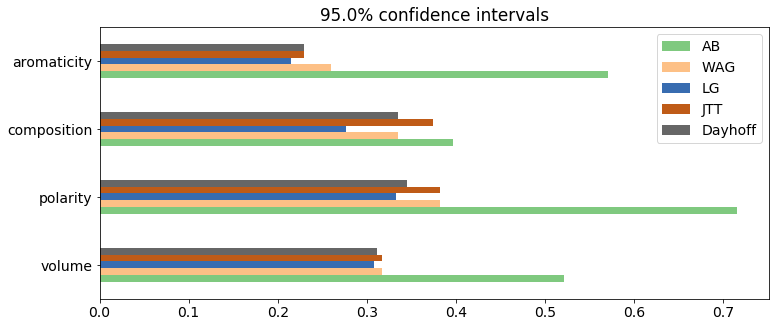

In [2825]:
Conf_int = utils.CI_from_null(null_dist, 0.95, )
                              

### Observed test statistics

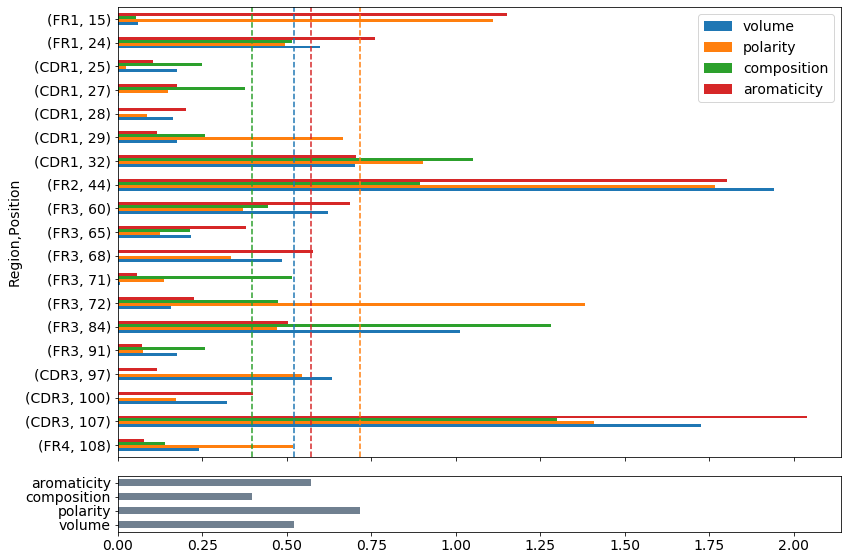

In [2826]:
utils.plot_observed_stats(CG_1615, Delta, Conf_int, model = 'AB', )

In [2822]:
output = utils.create_output_df(CG_1615, Delta, Conf_int, 'AB',)

In [2823]:
output

,Region,Position,volume,polarity,composition,aromaticity,volume_CI_max,polarity_CI_max,composition_CI_max,aromaticity_CI_max
0,FR1,15,0.059880,1.111111,0.054545,1.150386,0.898263,1.222222,0.88,1.0
1,FR1,24,0.598802,0.493827,0.516364,0.759640,0.898263,1.222222,0.88,1.0
2,CDR1,25,0.173653,0.024691,0.247273,0.102828,0.898263,1.222222,0.88,1.0
3,CDR1,27,0.002994,0.148148,0.374545,0.176093,0.898263,1.222222,0.88,1.0
4,CDR1,28,0.161677,0.086420,0.000000,0.200514,0.898263,1.222222,0.88,1.0
5,CDR1,29,0.173653,0.666667,0.258182,0.114396,0.898263,1.222222,0.88,1.0
6,CDR1,32,0.700599,0.901235,1.050909,0.704370,0.898263,1.222222,0.88,1.0
7,FR2,44,1.940120,1.765432,0.894545,1.800771,0.898263,1.222222,0.88,1.0
8,FR3,60,0.622754,0.370370,0.443636,0.686375,0.898263,1.222222,0.88,1.0
9,FR3,65,0.215569,0.123457,0.214545,0.379177,0.898263,1.222222,0.88,1.0


In [2827]:
Conf_int

,AB,WAG,LG,JTT,Dayhoff
volume,0.520958,0.317365,0.308533,0.317365,0.311377
polarity,0.716049,0.382716,0.333333,0.382716,0.345679
composition,0.396364,0.334909,0.276545,0.374545,0.334545
aromaticity,0.570694,0.259640,0.214781,0.230077,0.230077
